# Map geometry changes

Investigation on inconsistent geometry between versions detailed in issue #75.

In [9]:
from psycopg2 import connect
from psycopg2 import sql
from psycopg2.extras import execute_values
from pathlib import Path
import pandas as pd
import geopandas as gpd
import pandas.io.sql as pandasql
import configparser
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
connection_engine = create_engine(
    URL.create(
        drivername = "postgresql",
        host = CONFIG['DBSETTINGS']['host'],
        database = CONFIG['DBSETTINGS']['database'],
        username = CONFIG['DBSETTINGS']['user'],
        password = CONFIG['DBSETTINGS']['password']))
cur = connection_engine.raw_connection().cursor()

There are 43504 links that has the same link_dir as the previous version

In [3]:
sql = '''
select count(1) from congestion.network_links_23_4
inner join congestion.network_links_22_2 using (link_dir)
'''
with con : 
    nodes = pandasql.read_sql(sql, connection_engine) 
nodes.head()  

,count
0,43504


There are 4701 link_dirs (about 11%) with different geometries.

In [7]:
sql = '''
-- Find how many link has the same geometry using ST_Equals

select count(1) from congestion.network_links_23_4_geom v23
inner join congestion.network_links_22_2 v22 using (link_dir)
where not ST_Equals(v22.geom,v23.geom) 
'''
with con : 
    nodes = pandasql.read_sql(sql, connection_engine) 
nodes.head()  

,count
0,4701


There are located around here, the highway is showing up a bit, as well as Finch and Leslie, Weston Rd, and Eglinton Ave.

In [12]:
new_links = '''
select link_dir, gis.geopandas_transform(v23.geom) as geom 
from congestion.network_links_23_4_geom v23
inner join congestion.network_links_22_2 v22 using (link_dir)
where not ST_Equals(v22.geom,v23.geom)   
                '''
new_links = gpd.GeoDataFrame.from_postgis(new_links, con, geom_col='geom')
new_links = new_links.to_crs('epsg:26917')

/data/jupyterhub/.venv/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


<Axes: >

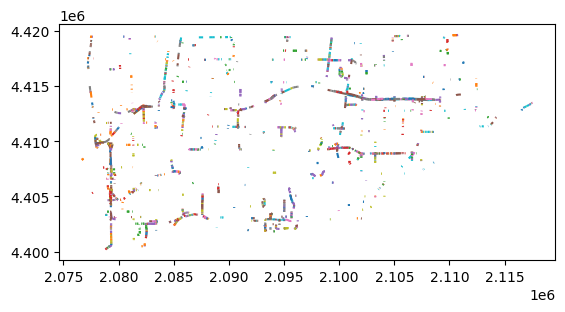

In [16]:
new_links.plot(column = 'link_dir')

Only 115 segments has a length difference more than 5m. 

In [20]:
sql = '''
select count(1)
from congestion.network_segments v22
inner join congestion.network_segments_23_4_geom v23 using (segment_id)
where abs(v23.total_length -  v22.total_length) >5
'''
with con : 
    nodes = pandasql.read_sql(sql, connection_engine) 
nodes.head()  

,count
0,218


## Validate by routing and checking ST_isvalid

In [ ]:
'''
with affected as (
	select v22.segment_id, v22.start_vid, v22.end_vid, v22.direction
	from congestion.network_segments v22
	inner join congestion.network_segments_23_4_geom v23 using (segment_id)
	where abs(v23.total_length -  v22.total_length) > 5)

, validate_nodes AS (
	SELECT affected.segment_id, affected.start_vid, affected.end_vid, re.start_vid as source, rere.end_vid  as target
	from affected 
	left join congestion.network_segments_23_4_geom re on affected.start_vid = re.end_vid
	left join congestion.network_segments_23_4_geom rere on affected.end_vid = rere.start_vid
	where affected.direction = re.direction and affected.direction = rere.direction
	order by affected.segment_id)

select validate_nodes.segment_id as test_id, 
		validate_nodes.start_vid, validate_nodes.end_vid, 
		array_agg(edge) AS segments, 
		ST_isvalid(ST_linemerge(ST_Union(geom))), 
		ST_linemerge(ST_Union(geom)) AS geom 
from validate_nodes
, LATERAL pgr_dijkstra('SELECT segment_id as id, start_vid::int as source, end_vid::int as target, 
					   st_length(st_transform(geom, 2952)) as cost 
						FROM congestion.network_segments_23_4_geom
					   ',
				source, target) results
INNER JOIN congestion.network_segments_23_4_geom ON segment_id = edge
group by validate_nodes.segment_id, validate_nodes.start_vid, validate_nodes.end_vid
'''

All 177 segments that got routed has a valid geometry. Looking at the map, as geometries of the link_dir swifted, the nodes geometry swifted as well, the resulted segments at the end is still routable, just looks a little different. For example:

![image](https://github.com/CityofToronto/bdit_congestion/assets/46324452/6c6f9ad7-8682-4666-ad87-a686a4fd74ce)
![image](https://github.com/CityofToronto/bdit_congestion/assets/46324452/1884bbd7-3ebd-498d-9269-ebcf50ec65ee)


Now on to the ones that did not get routed, there are 46.

Looks totally fine. They likely did not get routed because I added a clause where the adjacent segments for routing has to have the same direction, and these segments' adjacent segmetns often does not have the same direction.

![image](https://github.com/CityofToronto/bdit_congestion/assets/46324452/7c1ef0d6-7a21-49b8-b64a-f8e2a8c8e999)
![image](https://github.com/CityofToronto/bdit_congestion/assets/46324452/6a22b414-cd60-49d9-b2df-f48861f50d23)
